In [56]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
chunksize = 370 #approximately 31685708 entries

df = pd.DataFrame()
curr_chunk = 0
data=pd.read_csv('all_skills_sorted.tsv', sep='\t', chunksize=chunksize)

for chunk in data:
    rand_person = chunk.sample(n=1)
    df = pd.concat([df, rand_person])
    
    # log progress
    curr_chunk += 1
    if curr_chunk % 10000 == 0:
        print(curr_chunk)

df.columns = ['subclass', 'skills']
df

10000
20000
30000
40000
50000
60000
70000
80000


,subclass,skills
264,"[('Accounting and Auditing', 0.150462075345712...","Finance,Strategic Planning,Networking"
507,"[('Accounting and Auditing', 0.160385127018838...","Accounting,Risk Management,Management,Microsof..."
992,"[('Accounting and Auditing', 0.172524060876110...","ERP,Multi-location,Project Management,Tax,CRM,..."
1201,"[('Accounting and Auditing', 0.175722937264015...","Financial Analysis,Financial Accounting,Accoun..."
1831,"[('Accounting and Auditing', 0.184710048608983...","Management,Strategic Planning,Business Plannin..."
1850,"[('Accounting and Auditing', 0.185016720335264...","Leadership,Analysis,Finance,Data Analysis,Rese..."
2400,"[('Accounting and Auditing', 0.191140615137366...","SAP,Purchasing,Teamwork,Team Leadership,Micros..."
2728,"[('Accounting and Auditing', 0.194373874274696...","Foreign Languages,Accounting,Marketing,Human R..."
3107,"[('Accounting and Auditing', 0.197372331045185...",Business Object SAP Qlikview Hyperion requ...
3637,"[('Accounting and Auditing', 0.201351754101999...","French,Financial Reporting,Business Strategy,F..."


In [58]:
corpus = []
for skills in df['skills']:
    corpus.append(skills)
print(str(len(corpus)) + ' sampled people')

85638 sampled people


In [68]:
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(','), min_df=10) #drop sparse entries < 10 in corpus
data_vectorized = normalize(vectorizer.fit_transform(corpus))

# convert sparse matrix to full
data_processed = data_vectorized.toarray()
print(data_processed.shape)

/Users/ericgan/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


(85638, 9197)


In [69]:
lda = LatentDirichletAllocation(n_topics=44, max_iter=500) #change max_iter to 500
lda_output = lda.fit_transform(data_processed)
print(lda)
print(lda_output.shape)
print(lda.components_.shape)

/Users/ericgan/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=500,
             mean_change_tol=0.001, n_jobs=1, n_topics=44, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)
(85638, 44)
(44, 9197)


In [70]:
# higher the better
print(lda.score(data_vectorized))

# lower the better
print(lda.perplexity(data_vectorized))

-12758181.367268434
1.7130364422559202e+16


In [71]:
# column names
skillsets = ["Skill" + str(i) for i in range(lda.n_topics)]
# row names
people = ["Person" + str(i) for i in range(len(data_vectorized.toarray()))]

# create data frame relating people to each of the skillsets
df_people_skills = pd.DataFrame(np.round(lda_output, 2), columns=skillsets, index=people)

# Get dominant skill for each person
dominant_skill = np.argmax(df_people_skills.values, axis=1)
df_people_skills['Dominant Skill'] = dominant_skill

df_people_skills.head(15)

,Skill0,Skill1,Skill2,Skill3,Skill4,Skill5,Skill6,Skill7,Skill8,Skill9,...,Skill35,Skill36,Skill37,Skill38,Skill39,Skill40,Skill41,Skill42,Skill43,Dominant Skill
Person0,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.23,0.22,0.01,0.01,0.01,0.01,0.01,37
Person1,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,12
Person2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.26,0.00,0.00,0.00,0.00,0.00,0.00,12
Person3,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12
Person4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.24,0.00,0.00,0.00,0.00,0.00,0.00,12
Person5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12
Person6,0.00,0.03,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.29,0.00,0.00,0.00,0.00,12
Person7,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,12
Person8,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,12
Person9,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.33,0.00,0.00,0.00,0.00,0.00,0.00,37


In [72]:
df_skill_distribution = df_people_skills['Dominant Skill'].value_counts().reset_index(name='skill counts')
df_skill_distribution.columns = ['Skill Num', 'Num People']
df_skill_distribution

,Skill Num,Num People
0,12,43362
1,11,12028
2,37,4838
3,34,3577
4,15,3412
5,20,1925
6,26,1832
7,31,1797
8,4,1781
9,39,1617


<Container object of 42 artists>

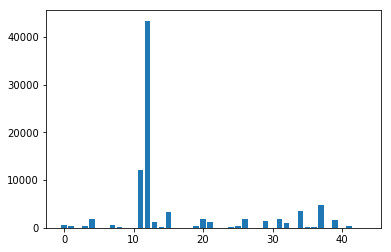

In [73]:
plt.bar(df_skill_distribution['Skill Num'], df_skill_distribution['Num People'])

In [74]:
# Topic-Keyword Matrix
df_skill_keywords = pd.DataFrame(lda.components_)
# Assign Column and Index
df_skill_keywords.columns = vectorizer.get_feature_names()
df_skill_keywords.index = skillsets

df_skill_keywords.head()

,.net,.net framework,10 key,1031 exchanges,21 cfr part 11,2d animation,2d art,2d graphics,2g,360 feedback,...,营销,营销战略,谈判,财务分析,跨职能团队领导力,销售管理,项目管理,项目规划,顾客服务,领导力
Skill0,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,...,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727
Skill1,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,...,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727
Skill2,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,...,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727
Skill3,0.022727,0.022727,16.175749,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,...,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727
Skill4,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,...,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727


In [75]:
# Show top k keywords for each skill
def show_topics(vectorizer, lda_model, k_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        # sort in descending order
        top_keyword_idx = (-topic_weights).argsort()[:k_words]
        topic_keywords.append(keywords.take(top_keyword_idx))
    return topic_keywords

In [76]:
# Topic - Keywords Dataframe
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda, k_words=15)
df_skill_keywords = pd.DataFrame(topic_keywords)
df_skill_keywords.columns = ['Word '+ str(i) for i in range(df_skill_keywords.shape[1])]
df_skill_keywords.index = ['Skill '+ str(i) for i in range(df_skill_keywords.shape[0])]
df_skill_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Skill 0,electrical engineering,social services,crisis intervention,instrumentation,plc,haccp,scada,tpm,motivational interviewing,autism spectrum disorders,windows 8,amélioration des processus,mep,online communications,microsoft visual studio c++
Skill 1,spss,brand development,civil litigation,interior design,statistics,web applications,life sciences,databases,html 5,architectural design,gmp,german,personal training,hplc,investigation
Skill 2,.net,phpunit,phpmyadmin,php4/5,php frameworks,php applications,php,photovoltaics,photoshop elements,photoshop,photos,photonics,photolithography,photojournalism,photography
Skill 3,grant writing,integrated marketing,environmental awareness,solution architecture,contractors,commercial litigation,stratégie commerciale,stratégie marketing,hotel management,mobile applications,français,commercial insurance,condos,flash,primavera p6
Skill 4,php,planificación estratégica,microsoft excel,gestión de proyectos,itil,administración y dirección de empresas,web development,estrategia empresarial,mysql,media relations,liderazgo,civil engineering,trabajo en equipo,investigación y desarrollo,music production
Skill 5,fha,sound design,usda,va loans,fha financing,recording,studio recording,short sales,government loans,reo,composition,certified mortgage planning,referrals,construction loans,sound editing
Skill 6,física,ciencias,c (programación),simulations,multivariate statistics,qt,monte carlo simulation,statistical software,educación superior,capacitación docente,liderazgo escolar,diseño curricular,desarrollo curricular,tecnología educativa,clases de repaso
Skill 7,illustrator,video production,treatment,web services,asp.net,apparel,google analytics,broadcast,painting,military experience,military,projektmanagement,web analytics,operational planning,subcontracting
Skill 8,hospitality,food & beverage,restaurants,menu development,banquets,culinary skills,cuisine,microsoft crm,new restaurant openings,navision,product knowledge,great plains software,concierge services,recipes,rooms division
Skill 9,higher education,distance learning,instructional technology,affiliate marketing,appraisals,digital imaging,online gaming,experimentation,casino,student recruiting,gaming industry,experimental design,public transport,internal & external communications,payment systems


In [ ]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
panel